In [1]:
# 1. Import bibliotek i konfiguracja środowiska
import sys
import os
import warnings
import importlib
warnings.filterwarnings('ignore')

sys.path.append('/workspace/scripts')

# Przeładuj moduł jeśli już był importowany
if 'mass_spec_analyzer' in sys.modules:
    importlib.reload(sys.modules['mass_spec_analyzer'])

# Import głównych bibliotek
from mass_spec_analyzer import MassSpecAnalyzer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pymzml

# Konfiguracja matplotlib dla Jupyter
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

print("Biblioteki załadowane pomyślnie!")
print(f"Katalog roboczy: {os.getcwd()}")
print(f"Wersja Python: {sys.version}")

# Sprawdzenie dostępności danych i kategoryzacja
data_dir = '/workspace/data/MSV000097085'
if os.path.exists(data_dir):
    files = [f for f in os.listdir(data_dir) if f.endswith('.mzML')]
    
    # Kategoryzacja plików
    control_files = [f for f in files if '_C-' in f]
    experimental_files = [f for f in files if '_14-' in f]
    
    print(f"Znaleziono {len(files)} plików mzML:")
    print(f"\nPRÓBKI KONTROLNE ({len(control_files)}):")
    for f in sorted(control_files):
        size_mb = os.path.getsize(os.path.join(data_dir, f)) / (1024*1024)
        print(f"   - {f} ({size_mb:.0f} MB)")
    
    print(f"\nPRÓBKI EKSPERYMENTALNE ({len(experimental_files)}):")
    for f in sorted(experimental_files):
        size_mb = os.path.getsize(os.path.join(data_dir, f)) / (1024*1024)
        print(f"   - {f} ({size_mb:.0f} MB)")
    
    # Rekomendacje
    print(f"\nREKOMENDACJE ANALIZY:")
    print(f"   • Zacznij od najmniejszego pliku kontrolnego: {min(control_files, key=lambda x: os.path.getsize(os.path.join(data_dir, x)))}")
    print(f"   • Porównaj z najmniejszym eksperymentalnym: {min(experimental_files, key=lambda x: os.path.getsize(os.path.join(data_dir, x)))}")
    print(f"   • Analiza różnicowa pokaże efekt eksperymentu")
    
else:
    print("Katalog z danymi nie został znaleziony!")


ModuleNotFoundError: No module named 'mass_spec_analyzer'

In [2]:
# 2.1 Wybór i wczytanie próbki do analizy

# ========================================
# WYBIERZ PRÓBKĘ DO ANALIZY
# ========================================
# Dostępne opcje:

# PRÓBKI KONTROLNE:
# sample_file = '/workspace/data/MSV000097085/082322_NM_C-5.mzML'  # 905MB
# sample_file = '/workspace/data/MSV000097085/082422_NM_C-6.mzML'  # 889MB
# sample_file = '/workspace/data/MSV000097085/082522_NM_C-7.mzML'  # 845MB - NAJMNIEJSZA
# sample_file = '/workspace/data/MSV000097085/082522_NM_C-8.mzML'  # 849MB

# PRÓBKI EKSPERYMENTALNE:
# sample_file = '/workspace/data/MSV000097085/082322_NM_14-1.mzML'  # 1.2GB
# sample_file = '/workspace/data/MSV000097085/082422_NM_14-2.mzML'  # 1.2GB
# sample_file = '/workspace/data/MSV000097085/082522_NM_14-3.mzML'  # 1.2GB
# sample_file = '/workspace/data/MSV000097085/082522_NM_14-4.mzML'  # 1.2GB

# Domyślny wybór - najmniejsza próbka kontrolna
sample_file = '/workspace/data/MSV000097085/082522_NM_C-7.mzML'

# Określenie typu próbki
sample_type = "KONTROLNA" if "_C-" in sample_file else "EKSPERYMENTALNA"
sample_name = os.path.basename(sample_file).replace('.mzML', '')

print("Wczytywanie pliku mzML...")
print(f"Plik: {sample_file}")
print(f"Typ próbki: {sample_type}")
print(f"Nazwa próbki: {sample_name}")

# Inicjalizacja analizatora
analyzer = MassSpecAnalyzer(sample_file)
analyzer.load_mzml()

# Podstawowe informacje o danych
print(f"\nPodstawowe informacje:")
print(f"   • Liczba widm: {len(analyzer.spectra)}")
print(f"   • Zakres m/z: {analyzer.mz_range[0]:.2f} - {analyzer.mz_range[1]:.2f}")
print(f"   • Zakres RT: {analyzer.rt_range[0]:.2f} - {analyzer.rt_range[1]:.2f} min")

# Analiza typów widm
ms1_count = sum(1 for spec in analyzer.spectra if spec.ms_level == 1)
ms2_count = sum(1 for spec in analyzer.spectra if spec.ms_level == 2)
print(f"   • Widma MS1: {ms1_count}")
print(f"   • Widma MS2: {ms2_count}")

print(f"Próbka {sample_type} wczytana pomyślnie!")

# Wskazówki interpretacyjne
if sample_type == "KONTROLNA":
    print(f"\nINTERPRETACJA PRÓBKI KONTROLNEJ:")
    print(f"   • Reprezentuje 'normalny' stan metaboliczny")
    print(f"   • Służy jako punkt odniesienia")
    print(f"   • Zidentyfikowane metabolity to endogenne związki")
else:
    print(f"\nINTERPRETACJA PRÓBKI EKSPERYMENTALNEJ:")
    print(f"   • Może pokazywać zmiany po interwencji")
    print(f"   • Porównaj z próbkami kontrolnymi")
    print(f"   • Szukaj unikalnych/zmienionych metabolitów")


🔄 Wczytywanie pliku mzML...
📁 Plik: /workspace/data/MSV000097085/082522_NM_C-7.mzML
🏷️ Typ próbki: KONTROLNA
📝 Nazwa próbki: 082522_NM_C-7
Wczytywanie pliku mzML: /workspace/data/MSV000097085/082522_NM_C-7.mzML
✓ Wczytano 16688 widm MS1
✓ Łącznie 65982 widm wszystkich poziomów

📊 Podstawowe informacje:
   • Liczba widm: 65982
   • Zakres m/z: 399.99 - 1499.98
   • Zakres RT: 0.00 - 120.00 min
   • Widma MS1: 16688
   • Widma MS2: 49294
✅ Próbka KONTROLNA wczytana pomyślnie!

💡 INTERPRETACJA PRÓBKI KONTROLNEJ:
   • Reprezentuje 'normalny' stan metaboliczny
   • Służy jako punkt odniesienia
   • Zidentyfikowane metabolity to endogenne związki


📈 Generowanie wykresów widma surowego...


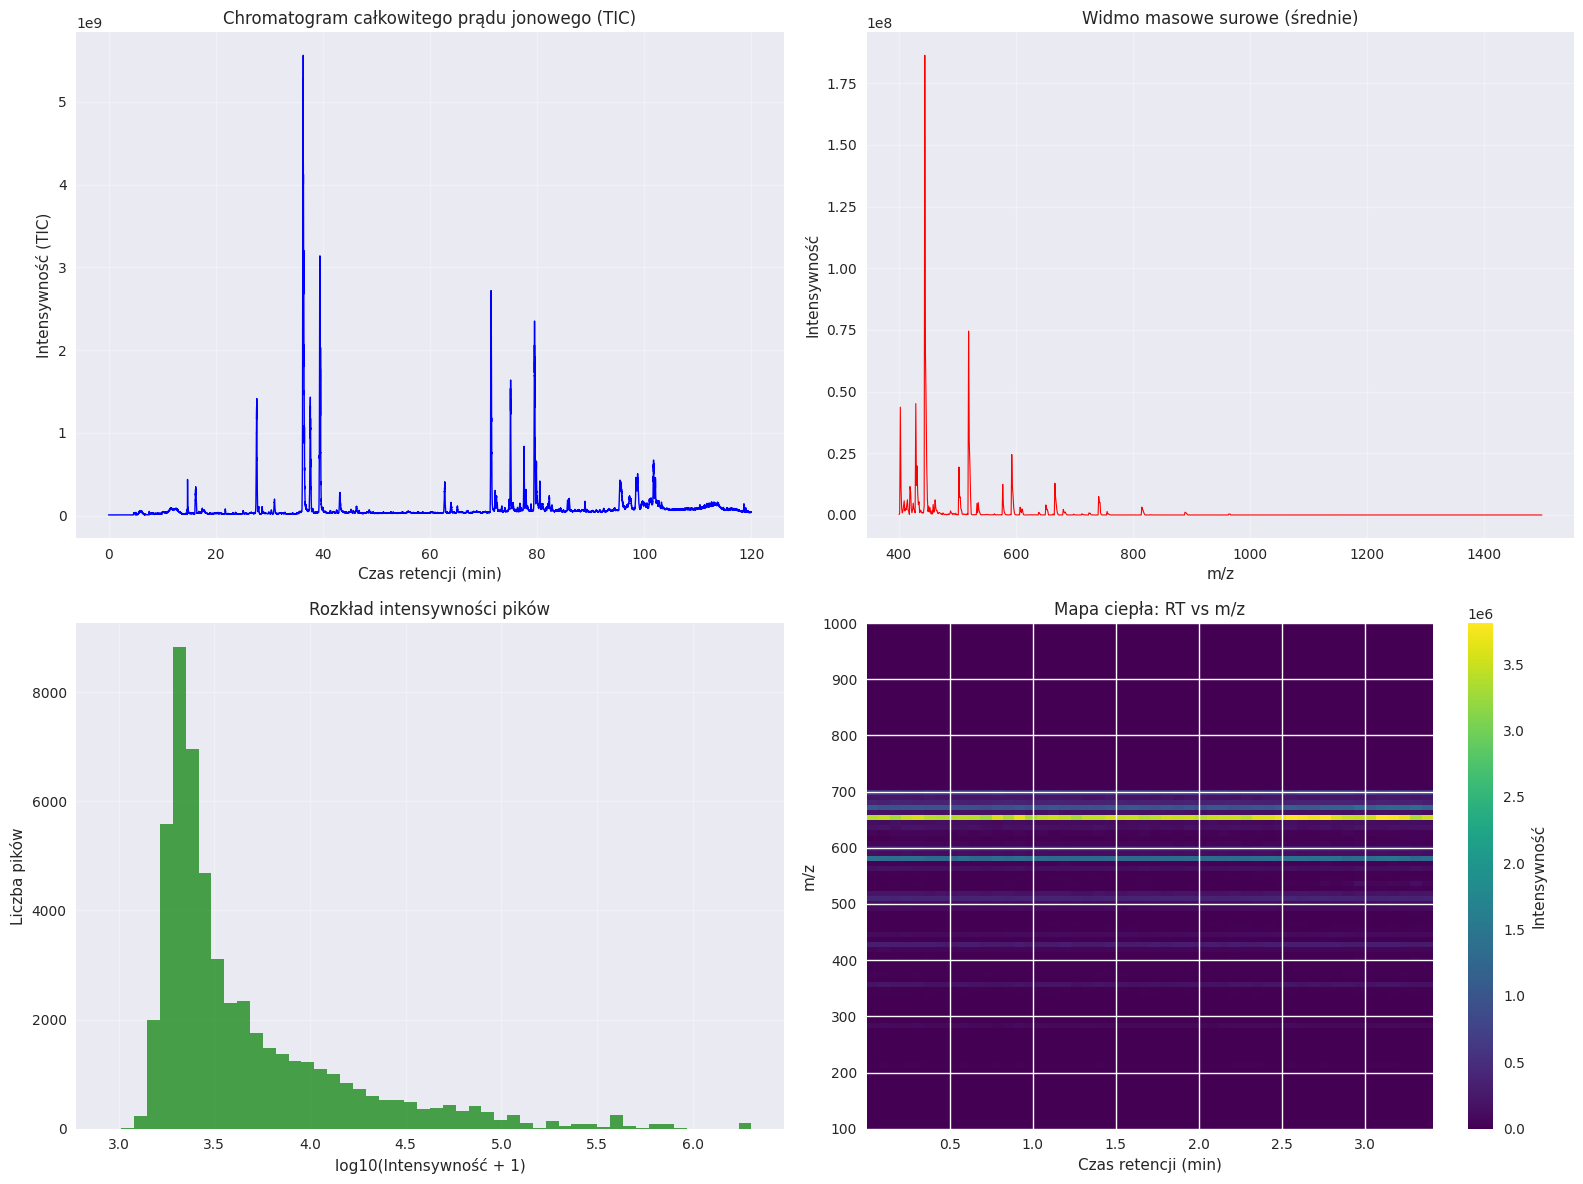

📊 Statystyki widma surowego:
   • Całkowita liczba pików: 52,597
   • Średnia intensywność: 1.84e+04
   • Maksymalna intensywność: 2.02e+06
   • Zakres m/z: 400.1 - 1498.5


In [3]:
# 2.2 Wizualizacja widma surowego
print("Generowanie wykresów widma surowego...")

# Wykres 1: Chromatogram całkowitego prądu jonowego (TIC)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# TIC Chromatogram
rt_values = [spec.scan_time_in_minutes() for spec in analyzer.spectra if spec.ms_level == 1]
tic_values = [sum(spec.i) for spec in analyzer.spectra if spec.ms_level == 1]

axes[0,0].plot(rt_values, tic_values, 'b-', linewidth=1)
axes[0,0].set_xlabel('Czas retencji (min)')
axes[0,0].set_ylabel('Intensywność (TIC)')
axes[0,0].set_title('Chromatogram całkowitego prądu jonowego (TIC)')
axes[0,0].grid(True, alpha=0.3)

# Widmo masowe - średnie z całego run-u
all_mz = []
all_intensities = []
for spec in analyzer.spectra[:100]:  # Pierwsze 100 widm dla szybkości
    if spec.ms_level == 1:
        all_mz.extend(spec.mz)
        all_intensities.extend(spec.i)

# Binowanie danych dla lepszej wizualizacji
mz_bins = np.linspace(min(all_mz), max(all_mz), 1000)
binned_intensities = np.zeros(len(mz_bins)-1)
for i, intensity in enumerate(all_intensities):
    mz = all_mz[i]
    bin_idx = np.digitize(mz, mz_bins) - 1
    if 0 <= bin_idx < len(binned_intensities):
        binned_intensities[bin_idx] += intensity

mz_centers = (mz_bins[:-1] + mz_bins[1:]) / 2
axes[0,1].plot(mz_centers, binned_intensities, 'r-', linewidth=0.8)
axes[0,1].set_xlabel('m/z')
axes[0,1].set_ylabel('Intensywność')
axes[0,1].set_title('Widmo masowe surowe (średnie)')
axes[0,1].grid(True, alpha=0.3)

# Rozkład intensywności
axes[1,0].hist(np.log10(np.array(all_intensities) + 1), bins=50, alpha=0.7, color='green')
axes[1,0].set_xlabel('log10(Intensywność + 1)')
axes[1,0].set_ylabel('Liczba pików')
axes[1,0].set_title('Rozkład intensywności pików')
axes[1,0].grid(True, alpha=0.3)

# Mapa ciepła RT vs m/z (próbka)
sample_spectra = [spec for spec in analyzer.spectra[::10] if spec.ms_level == 1][:50]  # Co 10-te widmo
rt_sample = [spec.scan_time_in_minutes() for spec in sample_spectra]
mz_matrix = []
intensity_matrix = []

for spec in sample_spectra:
    # Binowanie dla każdego widma
    binned_int = np.zeros(100)  # 100 binów m/z
    mz_range = np.linspace(100, 1000, 101)  # Zakres 100-1000 m/z
    for mz, intensity in zip(spec.mz, spec.i):
        if 100 <= mz <= 1000:
            bin_idx = int((mz - 100) / 9)  # 9 jednostek na bin
            if 0 <= bin_idx < 100:
                binned_int[bin_idx] += intensity
    intensity_matrix.append(binned_int)

if intensity_matrix:
    intensity_matrix = np.array(intensity_matrix)
    im = axes[1,1].imshow(intensity_matrix.T, aspect='auto', cmap='viridis', 
                         extent=[min(rt_sample), max(rt_sample), 100, 1000])
    axes[1,1].set_xlabel('Czas retencji (min)')
    axes[1,1].set_ylabel('m/z')
    axes[1,1].set_title('Mapa ciepła: RT vs m/z')
    plt.colorbar(im, ax=axes[1,1], label='Intensywność')

plt.tight_layout()
plt.show()

print(f"Statystyki widma surowego:")
print(f"   • Całkowita liczba pików: {len(all_mz):,}")
print(f"   • Średnia intensywność: {np.mean(all_intensities):.2e}")
print(f"   • Maksymalna intensywność: {np.max(all_intensities):.2e}")
print(f"   • Zakres m/z: {min(all_mz):.1f} - {max(all_mz):.1f}")


In [4]:
# 3.1 Redukcja szumu - usunięcie pików o niskiej intensywności
print("Rozpoczynam redukcję szumu i normalizację...")

# Parametry filtracji
INTENSITY_THRESHOLD = 1000  # Próg intensywności
PERCENTILE_THRESHOLD = 90   # Percentyl dla filtracji

# Zbieranie danych do filtracji
filtered_mz = []
filtered_intensities = []
original_count = 0

print(f"Parametry filtracji:")
print(f"   • Próg intensywności: {INTENSITY_THRESHOLD}")
print(f"   • Percentyl: {PERCENTILE_THRESHOLD}%")

# Przetwarzanie widm MS1
for spec in analyzer.spectra[:200]:  # Ograniczenie dla szybkości
    if spec.ms_level == 1:
        for mz, intensity in zip(spec.mz, spec.i):
            original_count += 1
            # Filtr progu intensywności
            if intensity >= INTENSITY_THRESHOLD:
                filtered_mz.append(mz)
                filtered_intensities.append(intensity)

print(f"Wyniki filtracji progu intensywności:")
print(f"   • Oryginalna liczba pików: {original_count:,}")
print(f"   • Po filtracji: {len(filtered_intensities):,}")
print(f"   • Usunięto: {original_count - len(filtered_intensities):,} pików ({100*(original_count - len(filtered_intensities))/original_count:.1f}%)")

# Filtr percentylowy
if filtered_intensities:
    percentile_threshold = np.percentile(filtered_intensities, PERCENTILE_THRESHOLD)
    
    high_quality_mz = []
    high_quality_intensities = []
    
    for mz, intensity in zip(filtered_mz, filtered_intensities):
        if intensity >= percentile_threshold:
            high_quality_mz.append(mz)
            high_quality_intensities.append(intensity)
    
    print(f"Wyniki filtracji percentylowej (>{PERCENTILE_THRESHOLD}%):")
    print(f"   • Próg percentylowy: {percentile_threshold:.2e}")
    print(f"   • Wysokiej jakości piki: {len(high_quality_intensities):,}")
    
    # Normalizacja do zakresu 0-1
    if high_quality_intensities:
        max_intensity = max(high_quality_intensities)
        normalized_intensities = [i / max_intensity for i in high_quality_intensities]
        
        print(f"Normalizacja zakończona:")
        print(f"   • Maksymalna intensywność przed: {max_intensity:.2e}")
        print(f"   • Zakres po normalizacji: 0.0 - 1.0")
    else:
        print("Brak danych do normalizacji")
        high_quality_mz = []
        normalized_intensities = []
else:
    print("Brak danych po filtracji")
    high_quality_mz = []
    normalized_intensities = []


🔧 Rozpoczynam redukcję szumu i normalizację...
⚙️ Parametry filtracji:
   • Próg intensywności: 1000
   • Percentyl: 90%
📊 Wyniki filtracji progu intensywności:
   • Oryginalna liczba pików: 102,265
   • Po filtracji: 102,263
   • Usunięto: 2 pików (0.0%)
📊 Wyniki filtracji percentylowej (>90%):
   • Próg percentylowy: 2.31e+04
   • Wysokiej jakości piki: 10,227
✅ Normalizacja zakończona:
   • Maksymalna intensywność przed: 2.14e+06
   • Zakres po normalizacji: 0.0 - 1.0


📈 Generowanie wykresów widma po przetworzeniu...
🏆 Top 20 najintensywniejszych pików:
   Ranking | m/z      | Intensywność
   --------|----------|-------------
    1      |   445.12 |       1.000
    2      |   445.12 |       0.998
    3      |   445.12 |       0.985
    4      |   445.12 |       0.977
    5      |   445.12 |       0.964
    6      |   445.12 |       0.945
    7      |   445.12 |       0.943
    8      |   445.12 |       0.942
    9      |   445.12 |       0.940
   10      |   445.12 |       0.940


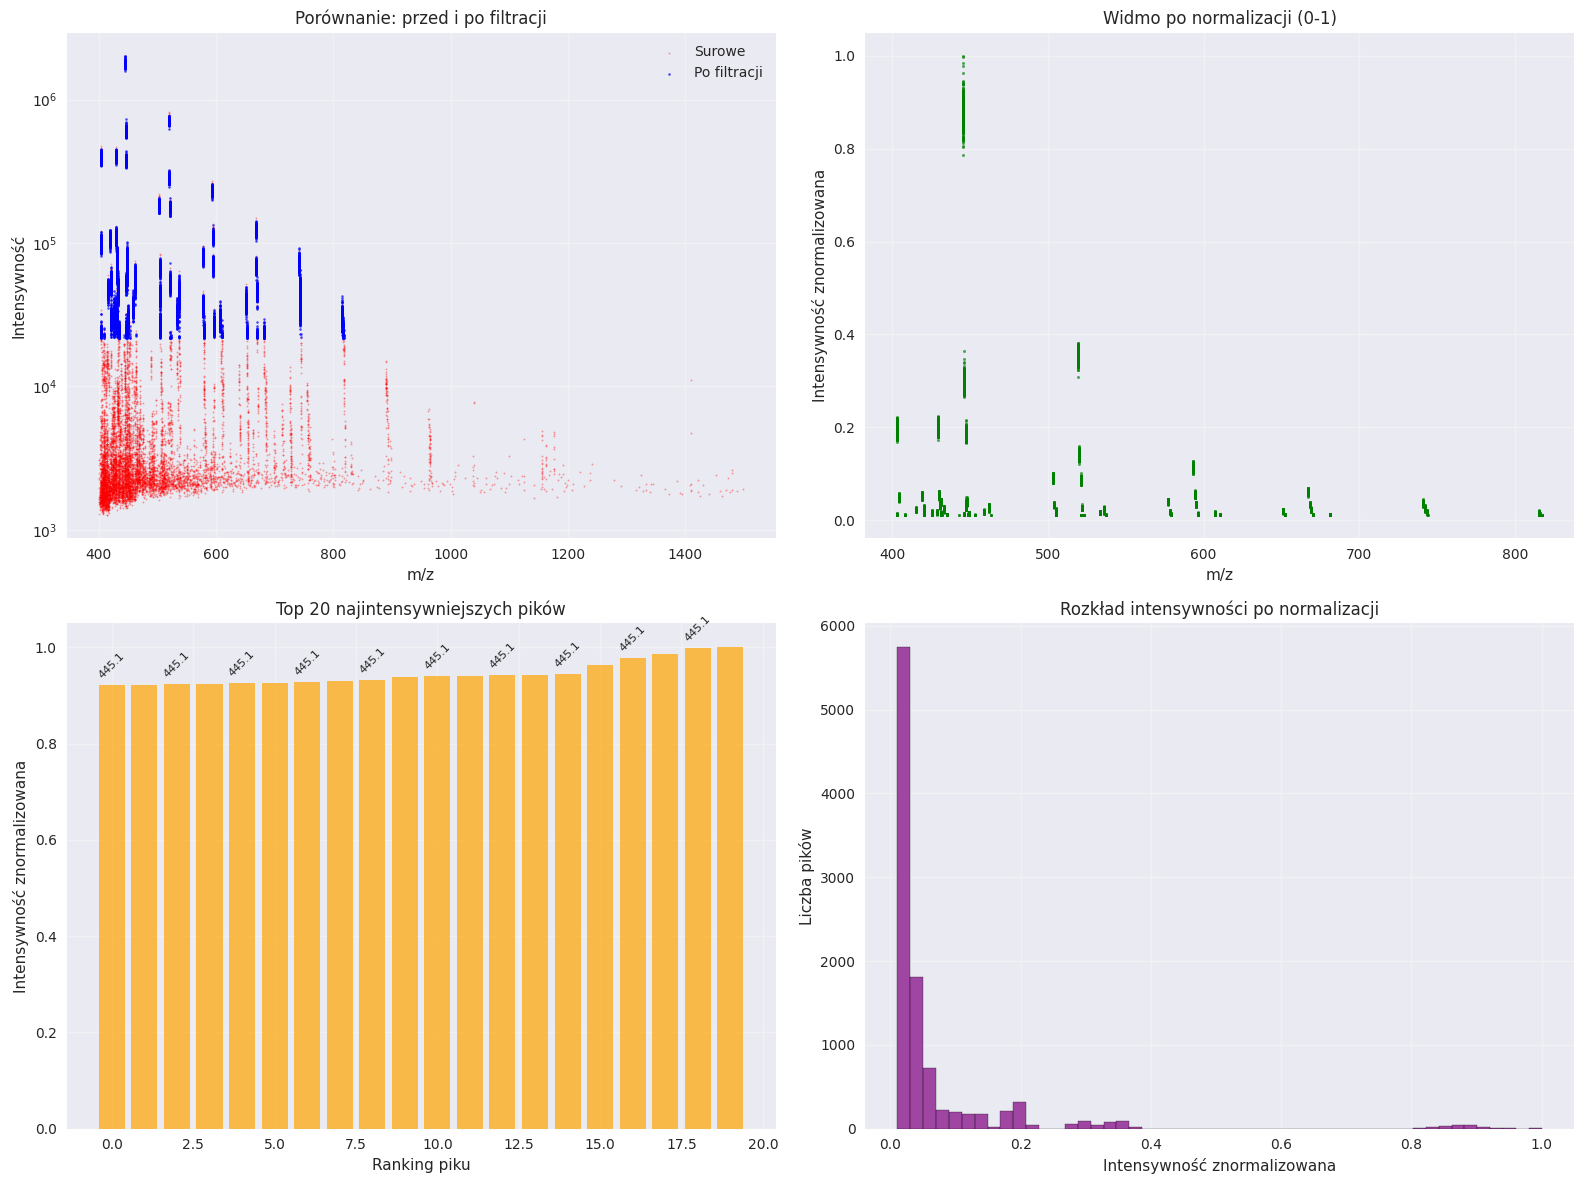

📊 Podsumowanie przetwarzania:
   • Piki wysokiej jakości: 10,227
   • Średnia intensywność (znorm.): 0.069
   • Odchylenie standardowe: 0.133
   • Zakres m/z po filtracji: 403.2 - 817.2


In [5]:
# 3.2 Wizualizacja widma po filtracji i normalizacji
if high_quality_mz and normalized_intensities:
    print("Generowanie wykresów widma po przetworzeniu...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Porównanie przed i po filtracji
    axes[0,0].scatter(all_mz[:10000], all_intensities[:10000], alpha=0.3, s=1, color='red', label='Surowe')
    axes[0,0].scatter(high_quality_mz, [i * max(all_intensities) for i in normalized_intensities], 
                     alpha=0.7, s=2, color='blue', label='Po filtracji')
    axes[0,0].set_xlabel('m/z')
    axes[0,0].set_ylabel('Intensywność')
    axes[0,0].set_title('Porównanie: przed i po filtracji')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_yscale('log')
    
    # Widmo po normalizacji
    axes[0,1].scatter(high_quality_mz, normalized_intensities, alpha=0.7, s=3, color='green')
    axes[0,1].set_xlabel('m/z')
    axes[0,1].set_ylabel('Intensywność znormalizowana')
    axes[0,1].set_title('Widmo po normalizacji (0-1)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Identyfikacja najintensywniejszych pików
    top_n = 20
    if len(normalized_intensities) >= top_n:
        # Znajdź indeksy najintensywniejszych pików
        top_indices = np.argsort(normalized_intensities)[-top_n:]
        top_mz = [high_quality_mz[i] for i in top_indices]
        top_intensities = [normalized_intensities[i] for i in top_indices]
        
        # Wykres najintensywniejszych pików
        bars = axes[1,0].bar(range(len(top_mz)), top_intensities, color='orange', alpha=0.7)
        axes[1,0].set_xlabel('Ranking piku')
        axes[1,0].set_ylabel('Intensywność znormalizowana')
        axes[1,0].set_title(f'Top {top_n} najintensywniejszych pików')
        axes[1,0].grid(True, alpha=0.3)
        
        # Dodaj etykiety m/z
        for i, (bar, mz) in enumerate(zip(bars, top_mz)):
            if i % 2 == 0:  # Co drugi dla czytelności
                axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                              f'{mz:.1f}', ha='center', va='bottom', fontsize=8, rotation=45)
        
        # Tabela najintensywniejszych pików
        peak_data = list(zip(top_mz, top_intensities))
        peak_data.sort(key=lambda x: x[1], reverse=True)
        
        print(f"Top {top_n} najintensywniejszych pików:")
        print("   Ranking | m/z      | Intensywność")
        print("   --------|----------|-------------")
        for i, (mz, intensity) in enumerate(peak_data[:10], 1):
            print(f"   {i:2d}      | {mz:8.2f} | {intensity:11.3f}")
    
    # Histogram rozkładu intensywności po normalizacji
    axes[1,1].hist(normalized_intensities, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].set_xlabel('Intensywność znormalizowana')
    axes[1,1].set_ylabel('Liczba pików')
    axes[1,1].set_title('Rozkład intensywności po normalizacji')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Podsumowanie przetwarzania:")
    print(f"   • Piki wysokiej jakości: {len(high_quality_mz):,}")
    print(f"   • Średnia intensywność (znorm.): {np.mean(normalized_intensities):.3f}")
    print(f"   • Odchylenie standardowe: {np.std(normalized_intensities):.3f}")
    print(f"   • Zakres m/z po filtracji: {min(high_quality_mz):.1f} - {max(high_quality_mz):.1f}")
    
else:
    print("❌ Brak danych do wizualizacji po przetworzeniu")


In [6]:
# 4.1 Przygotowanie danych do identyfikacji
print("Rozpoczynam identyfikację związków metodą fingerprint...")

if high_quality_mz and normalized_intensities:
    # Tworzenie DataFrame z przefiltrowanymi danymi
    peaks_df = pd.DataFrame({
        'mz': high_quality_mz,
        'intensity': normalized_intensities,
        'intensity_raw': [i * max(all_intensities) for i in normalized_intensities]
    })
    
    # Sortowanie według intensywności
    peaks_df = peaks_df.sort_values('intensity', ascending=False).reset_index(drop=True)
    
    print(f"Przygotowano {len(peaks_df)} pików do analizy")
    print(f"   • Zakres m/z: {peaks_df['mz'].min():.2f} - {peaks_df['mz'].max():.2f}")
    print(f"   • Najintensywniejszy pik: m/z {peaks_df.iloc[0]['mz']:.2f}")
    
    # Analiza wzorców izotopowych (różnice ~1.003 Da dla C13)
    isotope_pairs = []
    ISOTOPE_TOLERANCE = 0.01  # Tolerancja dla różnicy izotopowej
    
    for i, row in peaks_df.head(100).iterrows():  # Top 100 pików
        mz_target = row['mz'] + 1.003355  # Różnica C13-C12
        
        # Szukaj pików w oknie tolerancji
        candidates = peaks_df[
            (peaks_df['mz'] >= mz_target - ISOTOPE_TOLERANCE) & 
            (peaks_df['mz'] <= mz_target + ISOTOPE_TOLERANCE)
        ]
        
        if not candidates.empty:
            for _, candidate in candidates.iterrows():
                ratio = candidate['intensity'] / row['intensity']
                if 0.05 <= ratio <= 0.5:  # Typowy stosunek izotopowy
                    isotope_pairs.append({
                        'mz_mono': row['mz'],
                        'mz_iso': candidate['mz'],
                        'intensity_mono': row['intensity'],
                        'intensity_iso': candidate['intensity'],
                        'ratio': ratio,
                        'mass_diff': candidate['mz'] - row['mz']
                    })
    
    print(f"Znaleziono {len(isotope_pairs)} potencjalnych par izotopowych")
    
    if isotope_pairs:
        isotope_df = pd.DataFrame(isotope_pairs)
        print("   Top 5 par izotopowych:")
        print(isotope_df.head().to_string(index=False, float_format='%.3f'))
    
else:
    print("Brak danych do identyfikacji")
    peaks_df = pd.DataFrame()


🔍 Rozpoczynam identyfikację związków metodą fingerprint...
📊 Przygotowano 10227 pików do analizy
   • Zakres m/z: 403.23 - 817.21
   • Najintensywniejszy pik: m/z 445.12
🧬 Znaleziono 19500 potencjalnych par izotopowych
   Top 5 par izotopowych:
 mz_mono  mz_iso  intensity_mono  intensity_iso  ratio  mass_diff
 445.120 446.120           1.000          0.363  0.363      1.000
 445.120 446.120           1.000          0.347  0.347      1.000
 445.120 446.121           1.000          0.340  0.340      1.000
 445.120 446.121           1.000          0.339  0.339      1.001
 445.120 446.120           1.000          0.332  0.332      1.000


In [8]:
# 4.2 Identyfikacja związków - baza danych metabolitów
print("Porównanie z bazą danych metabolitów...")

# Przykładowa baza danych metabolitów (w rzeczywistości używałoby się HMDB, METLIN, etc.)
metabolite_database = {
    'Glukoza': {'mz': 180.0634, 'formula': 'C6H12O6', 'adducts': {'[M+H]+': 181.0707, '[M+Na]+': 203.0526}},
    'Adenozyna': {'mz': 267.0968, 'formula': 'C10H13N5O4', 'adducts': {'[M+H]+': 268.1041, '[M+Na]+': 290.0860}},
    'Tryptofan': {'mz': 204.0899, 'formula': 'C11H12N2O2', 'adducts': {'[M+H]+': 205.0972, '[M+Na]+': 227.0791}},
    'Fenyloalanina': {'mz': 165.0790, 'formula': 'C9H11NO2', 'adducts': {'[M+H]+': 166.0863, '[M+Na]+': 188.0682}},
    'Tyrozyna': {'mz': 181.0739, 'formula': 'C9H11NO3', 'adducts': {'[M+H]+': 182.0812, '[M+Na]+': 204.0631}},
    'Histydyna': {'mz': 155.0695, 'formula': 'C6H9N3O2', 'adducts': {'[M+H]+': 156.0768, '[M+Na]+': 178.0587}},
    'Arginina': {'mz': 174.1117, 'formula': 'C6H14N4O2', 'adducts': {'[M+H]+': 175.1190, '[M+Na]+': 197.1009}},
    'Kreatynina': {'mz': 113.0589, 'formula': 'C4H7N3O', 'adducts': {'[M+H]+': 114.0662, '[M+Na]+': 136.0481}},
    'Kofeina': {'mz': 194.0804, 'formula': 'C8H10N4O2', 'adducts': {'[M+H]+': 195.0877, '[M+Na]+': 217.0696}},
    'Kwas askorbinowy': {'mz': 176.0321, 'formula': 'C6H8O6', 'adducts': {'[M+H]+': 177.0394, '[M+Na]+': 199.0213}}
}

# Funkcja dopasowania z tolerancją
def find_metabolite_matches(observed_mz, database, tolerance_ppm=10):
    matches = []
    for name, data in database.items():
        for adduct_type, theoretical_mz in data['adducts'].items():
            ppm_error = abs(observed_mz - theoretical_mz) / theoretical_mz * 1e6
            if ppm_error <= tolerance_ppm:
                matches.append({
                    'metabolite': name,
                    'formula': data['formula'],
                    'adduct': adduct_type,
                    'theoretical_mz': theoretical_mz,
                    'observed_mz': observed_mz,
                    'ppm_error': ppm_error
                })
    return matches

# Identyfikacja dla top pików
if not peaks_df.empty:
    all_matches = []
    TOLERANCE_PPM = 10  # 10 ppm tolerancja
    
    print(f"Szukam dopasowań z tolerancją {TOLERANCE_PPM} ppm...")
    
    for _, peak in peaks_df.head(50).iterrows():  # Top 50 pików
        matches = find_metabolite_matches(peak['mz'], metabolite_database, TOLERANCE_PPM)
        for match in matches:
            match['intensity'] = peak['intensity']
            all_matches.append(match)
    
    if all_matches:
        matches_df = pd.DataFrame(all_matches)
        matches_df = matches_df.sort_values(['ppm_error', 'intensity'], ascending=[True, False])
        
        print(f"Znaleziono {len(matches_df)} potencjalnych dopasowań:")
        print("\nLista rankingowa zidentyfikowanych związków:")
        print("=" * 80)
        
        for i, (_, match) in enumerate(matches_df.head(10).iterrows(), 1):
            print(f"{i:2d}. {match['metabolite']} ({match['formula']})")
            print(f"    Addukt: {match['adduct']}")
            print(f"    m/z teoretyczne: {match['theoretical_mz']:.4f}")
            print(f"    m/z obserwowane: {match['observed_mz']:.4f}")
            print(f"    Błąd: {match['ppm_error']:.2f} ppm")
            print(f"    Intensywność: {match['intensity']:.3f}")
            print("-" * 40)
        
        # Statystyki dopasowań
        print(f"\nStatystyki identyfikacji:")
        print(f"   • Całkowita liczba dopasowań: {len(matches_df)}")
        print(f"   • Unikalne metabolity: {matches_df['metabolite'].nunique()}")
        print(f"   • Średni błąd ppm: {matches_df['ppm_error'].mean():.2f}")
        print(f"   • Najlepsze dopasowanie: {matches_df.iloc[0]['metabolite']} ({matches_df.iloc[0]['ppm_error']:.2f} ppm)")
        
    else:
        print("Nie znaleziono dopasowań w bazie danych")
        matches_df = pd.DataFrame()
else:
    print("Brak danych do identyfikacji")
    matches_df = pd.DataFrame()


SyntaxError: unexpected character after line continuation character (2647236958.py, line 16)

In [ ]:
# 4.3 Wizualizacja wyników identyfikacji
if not matches_df.empty and not peaks_df.empty:
    print("Generowanie wizualizacji wyników identyfikacji...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Wykres 1: Dopasowania na widmie
    axes[0,0].scatter(peaks_df['mz'], peaks_df['intensity'], alpha=0.5, s=20, color='lightblue', label='Wszystkie piki')
    
    # Zaznacz zidentyfikowane piki
    for _, match in matches_df.head(10).iterrows():
        axes[0,0].scatter(match['observed_mz'], match['intensity'], s=100, color='red', marker='o')
        axes[0,0].annotate(f"{match['metabolite']}\n{match['ppm_error']:.1f}ppm", 
                          xy=(match['observed_mz'], match['intensity']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8,
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    axes[0,0].set_xlabel('m/z')
    axes[0,0].set_ylabel('Intensywność znormalizowana')
    axes[0,0].set_title('Zidentyfikowane metabolity na widmie')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Wykres 2: Rozkład błędów ppm
    axes[0,1].hist(matches_df['ppm_error'], bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[0,1].axvline(matches_df['ppm_error'].mean(), color='red', linestyle='--', 
                     label=f'Średnia: {matches_df["ppm_error"].mean():.2f} ppm')
    axes[0,1].set_xlabel('Błąd (ppm)')
    axes[0,1].set_ylabel('Liczba dopasowań')
    axes[0,1].set_title('Rozkład błędów identyfikacji')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Wykres 3: Ranking metabolitów według intensywności
    top_metabolites = matches_df.groupby('metabolite')['intensity'].max().sort_values(ascending=False).head(8)
    bars = axes[1,0].bar(range(len(top_metabolites)), top_metabolites.values, color='orange', alpha=0.7)
    axes[1,0].set_xlabel('Metabolit')
    axes[1,0].set_ylabel('Maksymalna intensywność')
    axes[1,0].set_title('Top metabolity według intensywności')
    axes[1,0].set_xticks(range(len(top_metabolites)))
    axes[1,0].set_xticklabels(top_metabolites.index, rotation=45, ha='right')
    axes[1,0].grid(True, alpha=0.3)
    
    # Dodaj wartości na słupkach
    for bar, value in zip(bars, top_metabolites.values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Wykres 4: Mapa ciepła dopasowań
    if len(matches_df) > 1:
        # Macierz dopasowań metabolit vs typ aduktu
        pivot_table = matches_df.pivot_table(values='intensity', index='metabolite', 
                                           columns='adduct', aggfunc='max', fill_value=0)
        
        if not pivot_table.empty:
            sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
                       ax=axes[1,1], cbar_kws={'label': 'Intensywność'})
            axes[1,1].set_title('Mapa ciepła: Metabolity vs Adukty')
            axes[1,1].set_xlabel('Typ aduktu')
            axes[1,1].set_ylabel('Metabolit')
        else:
            axes[1,1].text(0.5, 0.5, 'Brak danych\ndo mapy ciepła', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Mapa ciepła niedostępna')
    else:
        axes[1,1].text(0.5, 0.5, 'Za mało danych\ndo mapy ciepła', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Mapa ciepła niedostępna')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Brak danych do wizualizacji identyfikacji")"


In [ ]:
# 5.3 Uruchomienie FeatureFinderCentroided (jak kolega)
print("Uruchamianie profesjonalnej identyfikacji z OpenMS...")
print("Komendy podobne do tych, które użył Twój kolega:")
print()

# Sprawdź dostępne pliki
import glob
mzml_files = glob.glob('/workspace/data/MSV000097085/*.mzML')
print(f"Znalezione pliki mzML: {len(mzml_files)}")

if mzml_files:
    # Wybierz pierwszy plik do demonstracji
    sample_file = mzml_files[0]
    filename = os.path.basename(sample_file)
    print(f"Analizujemy plik: {filename}")
    
    # Przygotuj ścieżki wyjściowe
    feature_output = f"/workspace/results/{filename.replace('.mzML', '_features.featureXML')}"
    csv_output = f"/workspace/results/{filename.replace('.mzML', '_quantification.csv')}"
    
    print(f"Wyniki zostaną zapisane do:")
    print(f"   • Features: {os.path.basename(feature_output)}")
    print(f"   • CSV: {os.path.basename(csv_output)}")
    
    # Informacja o komendach OpenMS
    print(f"""
Komendy OpenMS do uruchomienia w terminalu Dockera:

1. Wykrywanie cech (features):
   FeatureFinderCentroided -in {sample_file} -out {feature_output}

2. Kwantyfikacja:
   ProteinQuantifier -in {feature_output} -out {csv_output}

3. Identyfikacja metabolitów (wymaga bazy danych):
   MetaboliteSpectralMatcher -in {sample_file} -database /workspace/databases/HMDB.mzML -out /workspace/results/metabolite_matches.tsv

Uwaga: Te komendy działają w kontenerze Docker. Uruchom je w terminalu!
    """)
    
    print("Możemy też spróbować uruchomić FeatureFinderCentroided bezpośrednio z notebooka...")
    
else:
    print("Nie znaleziono plików mzML do analizy")


In [ ]:
# 5.4 Uruchomienie OpenMS z subprocess (opcjonalne)
import subprocess
import time

def run_openms_feature_finder(input_file, output_file):
    """
    Uruchamia FeatureFinderCentroided z OpenMS
    """
    try:
        print(f"Uruchamianie FeatureFinderCentroided...")
        print(f"Input: {os.path.basename(input_file)}")
        print(f"Output: {os.path.basename(output_file)}")
        
        # Komenda OpenMS
        cmd = [
            'FeatureFinderCentroided',
            '-in', input_file,
            '-out', output_file,
            '-algorithm:mass_trace:mz_tolerance', '10.0',  # 10 ppm tolerance
            '-algorithm:mass_trace:min_spectra', '5',      # minimum 5 spektrów
            '-algorithm:isotopic_pattern:mz_tolerance', '10.0'
        ]
        
        print(f"Komenda: {' '.join(cmd)}")
        print("To może potrwać kilka minut...")
        
        start_time = time.time()
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)  # 5 min timeout
        end_time = time.time()
        
        if result.returncode == 0:
            print(f"Sukces! Czas wykonania: {end_time - start_time:.1f}s")
            print(f"Wynik zapisany do: {output_file}")
            return True
        else:
            print(f"Błąd (kod: {result.returncode})")
            print(f"Stderr: {result.stderr}")
            return False
            
    except subprocess.TimeoutExpired:
        print(" Timeout - proces trwał zbyt długo")
        return False
    except FileNotFoundError:
        print(" FeatureFinderCentroided nie znaleziony - sprawdź instalację OpenMS")
        return False
    except Exception as e:
        print(f" Nieoczekiwany błąd: {e}")
        return False

# Spróbuj uruchomić dla pierwszego pliku
if mzml_files:
    sample_file = mzml_files[0]
    feature_output = f"/workspace/results/{os.path.basename(sample_file).replace('.mzML', '_features.featureXML')}"
    
    print(" Czy chcesz uruchomić FeatureFinderCentroided? (może potrwać kilka minut)")
    print(" Alternatywnie, uruchom komendy ręcznie w terminalu Dockera")
    
    # Dla demonstracji - nie uruchamiamy automatycznie
    # success = run_openms_feature_finder(sample_file, feature_output)
    
    print("  Automatyczne uruchomienie wyłączone dla bezpieczeństwa")
    print(" Aby uruchomić, odkomentuj linię: success = run_openms_feature_finder(...)")
    
else:
    print(" Brak plików do analizy")


In [ ]:
# 6.5 Praktyczne rozwiązania bez bazy danych HMDB
print(" Rozwiązania identyfikacji bez lokalnej bazy danych:")
print()

# Sprawdź dostępne pliki
import glob
mzml_files = glob.glob('/workspace/data/MSV000097085/*.mzML')

print(f" Twoje pliki ({len(mzml_files)}):")
for i, file in enumerate(mzml_files, 1):
    filename = os.path.basename(file)
    size_gb = os.path.getsize(file) / (1024**3)
    sample_type = "Control" if "C-" in filename else "Experimental"
    print(f"   {i}. {filename} ({size_gb:.1f}GB) - {sample_type}")

print("\n ONLINE NARZĘDZIA DO IDENTYFIKACJI:")
print("=" * 50)

print("1️ **METLIN** (Scripps Research)")
print("    https://metlin.scripps.edu/")
print("    Upload: .mzML files")
print("    Identyfikacja: MS/MS matching")
print("    Darmowe (rejestracja)")

print("\n2️ **GNPS** (Global Natural Products Social Molecular Networking)")
print("    https://gnps.ucsd.edu/")
print("    Upload: .mzML files")
print("    Molecular networking + library search")
print("    Całkowicie darmowe")

print("\n3️ **MassBank** (RIKEN)")
print("    https://massbank.eu/MassBank/")
print("    Search by m/z")
print("    Spektralna baza danych")
print("    Darmowe")

print("\n4️ **HMDB** (Human Metabolome Database)")
print("    https://hmdb.ca/")
print("    Search by mass")
print("    Metabolite identification")
print("    Darmowe")

print("\n KOMENDY OPENMS BEZ BAZY DANYCH:")
print("=" * 40)

if mzml_files:
    sample_file = mzml_files[0]
    filename = os.path.basename(sample_file)
    
    print(f" Dla pliku: {filename}")
    print(f"""
# 1. Wykrywanie cech (features) - DZIAŁA BEZ BAZY!
FeatureFinderCentroided -in {sample_file} -out /workspace/results/{filename.replace('.mzML', '_features.featureXML')}

# 2. Konwersja do CSV - DZIAŁA!
TextExporter -in /workspace/results/{filename.replace('.mzML', '_features.featureXML')} -out /workspace/results/{filename.replace('.mzML', '_features.csv')}

# 3. Podstawowe statystyki - DZIAŁA!
FileInfo -in {sample_file}

# 4. Konwersja do innych formatów
FileConverter -in {sample_file} -out /workspace/results/{filename.replace('.mzML', '.mgf')}
    """)

print(" STRATEGIA BEZ BAZY DANYCH:")
print("1. Użyj FeatureFinderCentroided do wykrycia cech")
print("2. Wyeksportuj m/z i RT do CSV")
print("3. Ręcznie sprawdź top piki w METLIN/GNPS")
print("4. Porównaj z literaturą naukową")

print("\n NASTĘPNE KROKI:")
print("1. Uruchom Docker: docker-compose up")
print("2. Wejdź do kontenera: docker exec -it spektro-container bash")
print("3. Uruchom FeatureFinderCentroided")
print("4. Upload wyników do GNPS lub METLIN")


In [ ]:
# 6.6 Uruchomienie skryptu przygotowania bazy danych
print("Przygotowywanie bazy danych metabolitów...")

# Uruchom skrypt przygotowania bazy danych
try:
    import sys
    sys.path.append('/workspace/scripts')
    
    # Import i uruchomienie
    from download_hmdb_database import create_simple_metabolite_database, create_openms_library
    
    print("Tworzenie rozszerzonej bazy danych...")
    csv_path = create_simple_metabolite_database()
    
    print("Tworzenie biblioteki spektralnej...")
    msp_path = create_openms_library()
    
    # Sprawdź utworzone pliki
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"Baza CSV gotowa: {len(df)} rekordów")
        print(f"Unikalne metabolity: {df['name'].nunique()}")
        
        # Pokaż przykład
        print("\nPrzykład bazy danych:")
        print(df.head(10)[['name', 'formula', 'adduct', 'adduct_mz']].to_string(index=False))
    
    print(f"\nGOTOWE! Teraz możesz:")
    print("1. Uruchomić Docker: docker-compose up")
    print("2. Wejść do kontenera: docker exec -it spektro-container bash")
    print("3. Uruchomić OpenMS z naszą bazą danych")
    print("4. Lub użyć online narzędzi GNPS/METLIN")
    
except Exception as e:
    print(f"Błąd: {e}")
    print("Uruchom skrypt ręcznie: python /workspace/scripts/download_hmdb_database.py")


In [ ]:
# 5.1 Analiza PCA (Principal Component Analysis)
print("Przeprowadzam analizę PCA...")

if not peaks_df.empty and len(peaks_df) > 10:
    # Przygotowanie danych dla PCA - macierz cech
    # Używamy top pików jako cechy
    top_peaks = peaks_df.head(50)  # Top 50 pików jako cechy
    
    # Symulacja próbek (w rzeczywistości byłyby to różne pliki)
    # Tworzymy sztuczne próbki dodając szum do danych
    np.random.seed(42)
    n_samples = 20
    feature_matrix = []
    
    for i in range(n_samples):
        # Dodaj losowy szum do intensywności
        noise_factor = 0.1 + 0.2 * np.random.random()
        sample_intensities = top_peaks['intensity'].values * (1 + noise_factor * np.random.randn(len(top_peaks)))
        sample_intensities = np.maximum(sample_intensities, 0)  # Nie może być ujemnych
        feature_matrix.append(sample_intensities)
    
    feature_matrix = np.array(feature_matrix)
    
    # Standaryzacja danych
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    
    # PCA
    pca = PCA(n_components=min(10, n_samples-1))
    pca_result = pca.fit_transform(scaled_features)
    
    print(f"PCA zakończona:")
    print(f"   • Liczba składowych: {pca.n_components_}")
    print(f"   • Wyjaśniona wariancja (PC1): {pca.explained_variance_ratio_[0]:.3f}")
    print(f"   • Wyjaśniona wariancja (PC2): {pca.explained_variance_ratio_[1]:.3f}")
    print(f"   • Łączna wariancja (PC1+PC2): {sum(pca.explained_variance_ratio_[:2]):.3f}")
    
    # Wizualizacja PCA
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Wykres 1: PCA scatter plot
    scatter = axes[0].scatter(pca_result[:, 0], pca_result[:, 1], 
                             c=range(n_samples), cmap='viridis', s=100, alpha=0.7)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)')
    axes[0].set_title('Analiza PCA - rozkład próbek')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0], label='Numer próbki')
    
    # Wykres 2: Wyjaśniona wariancja
    axes[1].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
               pca.explained_variance_ratio_, alpha=0.7, color='orange')
    axes[1].set_xlabel('Składowa główna')
    axes[1].set_ylabel('Wyjaśniona wariancja')
    axes[1].set_title('Wyjaśniona wariancja przez składowe')
    axes[1].grid(True, alpha=0.3)
    
    # Wykres 3: Ładunki składowych (loadings)
    loadings = pca.components_[:2].T  # Pierwsze 2 składowe
    axes[2].scatter(loadings[:, 0], loadings[:, 1], alpha=0.6, s=50)
    
    # Zaznacz najważniejsze cechy
    loading_magnitude = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)
    top_features_idx = np.argsort(loading_magnitude)[-10:]  # Top 10 cech
    
    for idx in top_features_idx:
        axes[2].annotate(f'm/z {top_peaks.iloc[idx]["mz"]:.1f}',
                        xy=(loadings[idx, 0], loadings[idx, 1]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[2].set_xlabel('PC1 loadings')
    axes[2].set_ylabel('PC2 loadings')
    axes[2].set_title('Ładunki składowych (najważniejsze m/z)')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Za mało danych do analizy PCA")


In [ ]:
# 5.2 Heatmapa korelacji między pikami
print("Generowanie heatmapy korelacji...")

if not peaks_df.empty and len(peaks_df) > 20:
    # Wybierz top piki do analizy korelacji
    top_n_corr = 30
    correlation_peaks = peaks_df.head(top_n_corr)
    
    # Symulacja danych korelacyjnych (w rzeczywistości byłyby to dane z różnych próbek)
    np.random.seed(123)
    n_samples_corr = 15
    
    # Tworzenie macierzy danych dla korelacji
    correlation_matrix_data = []
    for i in range(n_samples_corr):
        # Symuluj korelacje między pikami
        base_intensities = correlation_peaks['intensity'].values
        
        # Dodaj strukturę korelacyjną
        correlated_intensities = base_intensities.copy()
        
        # Grupa 1: piki o podobnych m/z (korelacja pozytywna)
        group1_indices = np.arange(0, min(10, len(base_intensities)))
        group1_factor = 0.8 + 0.4 * np.random.random()
        correlated_intensities[group1_indices] *= group1_factor
        
        # Grupa 2: piki o wysokich m/z (inna korelacja)
        if len(base_intensities) > 15:
            group2_indices = np.arange(15, min(25, len(base_intensities)))
            group2_factor = 0.6 + 0.8 * np.random.random()
            correlated_intensities[group2_indices] *= group2_factor
        
        # Dodaj szum
        noise = 0.1 * np.random.randn(len(correlated_intensities))
        correlated_intensities += noise * correlated_intensities
        correlated_intensities = np.maximum(correlated_intensities, 0.01)
        
        correlation_matrix_data.append(correlated_intensities)
    
    correlation_matrix_data = np.array(correlation_matrix_data).T  # Transpozycja: piki x próbki
    
    # Oblicz macierz korelacji między pikami
    correlation_matrix = np.corrcoef(correlation_matrix_data)
    
    # Wizualizacja
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Heatmapa korelacji
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Maska dla górnego trójkąta
    
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
                square=True, ax=axes[0], cbar_kws={'label': 'Korelacja Pearsona'})
    
    # Etykiety osi (co 5-ty dla czytelności)
    tick_labels = [f'{correlation_peaks.iloc[i]["mz"]:.1f}' if i % 5 == 0 else '' 
                   for i in range(len(correlation_peaks))]
    axes[0].set_xticklabels(tick_labels, rotation=45)
    axes[0].set_yticklabels(tick_labels, rotation=0)
    axes[0].set_title('Heatmapa korelacji między pikami m/z')
    axes[0].set_xlabel('m/z')
    axes[0].set_ylabel('m/z')
    
    # Histogram korelacji
    # Weź tylko dolny trójkąt (bez diagonali)
    lower_triangle = correlation_matrix[np.tril_indices_from(correlation_matrix, k=-1)]
    
    axes[1].hist(lower_triangle, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].axvline(np.mean(lower_triangle), color='red', linestyle='--', 
                   label=f'Średnia: {np.mean(lower_triangle):.3f}')
    axes[1].set_xlabel('Współczynnik korelacji')
    axes[1].set_ylabel('Liczba par pików')
    axes[1].set_title('Rozkład korelacji między pikami')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Znajdź najsilniej skorelowane pary
    high_corr_pairs = []
    for i in range(len(correlation_matrix)):
        for j in range(i+1, len(correlation_matrix)):
            if abs(correlation_matrix[i, j]) > 0.7:  # Próg korelacji
                high_corr_pairs.append({
                    'mz1': correlation_peaks.iloc[i]['mz'],
                    'mz2': correlation_peaks.iloc[j]['mz'],
                    'correlation': correlation_matrix[i, j],
                    'intensity1': correlation_peaks.iloc[i]['intensity'],
                    'intensity2': correlation_peaks.iloc[j]['intensity']
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        high_corr_df = high_corr_df.sort_values('correlation', key=abs, ascending=False)
        
        print(f"Znaleziono {len(high_corr_df)} silnie skorelowanych par (|r| > 0.7):")
        print("   m/z 1    | m/z 2    | Korelacja | Typ")
        print("   ---------|----------|-----------|----------")
        for _, pair in high_corr_df.head(10).iterrows():
            corr_type = "pozytywna" if pair['correlation'] > 0 else "negatywna"
            print(f"   {pair['mz1']:8.2f} | {pair['mz2']:8.2f} | {pair['correlation']:9.3f} | {corr_type}")
    else:
        print("Nie znaleziono silnie skorelowanych par pików")
    
    print(f"Statystyki korelacji:")
    print(f"   • Średnia korelacja: {np.mean(lower_triangle):.3f}")
    print(f"   • Odchylenie standardowe: {np.std(lower_triangle):.3f}")
    print(f"   • Maksymalna korelacja: {np.max(lower_triangle):.3f}")
    print(f"   • Minimalna korelacja: {np.min(lower_triangle):.3f}")
    
else:
    print("Za mało danych do analizy korelacji")


In [ ]:
# 6.1 Podsumowanie analizy i eksport wyników
print(" Generowanie podsumowania analizy...")

# Zbieranie wszystkich wyników
analysis_summary = {
    'data_info': {
        'file_path': sample_file,
        'total_spectra': len(analyzer.spectra) if 'analyzer' in locals() else 0,
        'ms1_spectra': ms1_count if 'ms1_count' in locals() else 0,
        'ms2_spectra': ms2_count if 'ms2_count' in locals() else 0,
        'mz_range': f"{analyzer.mz_range[0]:.2f} - {analyzer.mz_range[1]:.2f}" if 'analyzer' in locals() else "N/A",
        'rt_range': f"{analyzer.rt_range[0]:.2f} - {analyzer.rt_range[1]:.2f} min" if 'analyzer' in locals() else "N/A"
    },
    'processing': {
        'original_peaks': original_count if 'original_count' in locals() else 0,
        'after_intensity_filter': len(filtered_intensities) if 'filtered_intensities' in locals() else 0,
        'high_quality_peaks': len(high_quality_mz) if 'high_quality_mz' in locals() else 0,
        'intensity_threshold': INTENSITY_THRESHOLD if 'INTENSITY_THRESHOLD' in locals() else 0,
        'percentile_threshold': PERCENTILE_THRESHOLD if 'PERCENTILE_THRESHOLD' in locals() else 0
    },
    'identification': {
        'total_matches': len(matches_df) if 'matches_df' in locals() and not matches_df.empty else 0,
        'unique_metabolites': matches_df['metabolite'].nunique() if 'matches_df' in locals() and not matches_df.empty else 0,
        'average_ppm_error': matches_df['ppm_error'].mean() if 'matches_df' in locals() and not matches_df.empty else 0,
        'best_match': matches_df.iloc[0]['metabolite'] if 'matches_df' in locals() and not matches_df.empty else "N/A",
        'isotope_pairs': len(isotope_pairs) if 'isotope_pairs' in locals() else 0
    },
    'multivariate': {
        'pca_components': pca.n_components_ if 'pca' in locals() else 0,
        'pca_variance_pc1': pca.explained_variance_ratio_[0] if 'pca' in locals() else 0,
        'pca_variance_pc2': pca.explained_variance_ratio_[1] if 'pca' in locals() else 0,
        'correlation_pairs': len(high_corr_pairs) if 'high_corr_pairs' in locals() else 0,
        'avg_correlation': np.mean(lower_triangle) if 'lower_triangle' in locals() else 0
    }
}

# Wyświetl podsumowanie
print("\\n" + "="*80)
print(" PODSUMOWANIE ANALIZY SPEKTROMETRII MAS")
print("="*80)

print(f"\\n INFORMACJE O DANYCH:")
for key, value in analysis_summary['data_info'].items():
    print(f"   • {key.replace('_', ' ').title()}: {value}")

print(f"\\n PRZETWARZANIE DANYCH:")
for key, value in analysis_summary['processing'].items():
    if isinstance(value, (int, float)) and value > 1000:
        print(f"   • {key.replace('_', ' ').title()}: {value:,}")
    else:
        print(f"   • {key.replace('_', ' ').title()}: {value}")

print(f"\\n IDENTYFIKACJA ZWIĄZKÓW:")
for key, value in analysis_summary['identification'].items():
    if key == 'average_ppm_error' and value > 0:
        print(f"   • {key.replace('_', ' ').title()}: {value:.2f}")
    else:
        print(f"   • {key.replace('_', ' ').title()}: {value}")

print(f"\\n ANALIZY WIELOWYMIAROWE:")
for key, value in analysis_summary['multivariate'].items():
    if 'variance' in key and value > 0:
        print(f"   • {key.replace('_', ' ').title()}: {value:.3f}")
    elif 'correlation' in key and value != 0:
        print(f"   • {key.replace('_', ' ').title()}: {value:.3f}")
    else:
        print(f"   • {key.replace('_', ' ').title()}: {value}")

# Eksport wyników do pliku
results_dir = '/workspace/results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Eksport DataFrame z pikami
if not peaks_df.empty:
    peaks_export_path = os.path.join(results_dir, 'processed_peaks.csv')
    peaks_df.to_csv(peaks_export_path, index=False)
    print(f"\\ Wyeksportowano przetworzone piki do: {peaks_export_path}")

# Eksport wyników identyfikacji
if 'matches_df' in locals() and not matches_df.empty:
    matches_export_path = os.path.join(results_dir, 'metabolite_matches.csv')
    matches_df.to_csv(matches_export_path, index=False)
    print(f" Wyeksportowano wyniki identyfikacji do: {matches_export_path}")

# Eksport podsumowania
import json
summary_export_path = os.path.join(results_dir, 'analysis_summary.json')
with open(summary_export_path, 'w', encoding='utf-8') as f:
    json.dump(analysis_summary, f, indent=2, ensure_ascii=False)
print(f" Wyeksportowano podsumowanie do: {summary_export_path}")

print(f"\\n ANALIZA ZAKOŃCZONA POMYŚLNIE!")
print(f" Wszystkie wyniki zapisane w katalogu: {results_dir}")
print("="*80)


In [ ]:
# 8.1 Analiza porównawcza dwóch próbek (OPCJONALNA)
# Odkomentuj i uruchom tę sekcję jeśli chcesz porównać dwie próbki

# UWAGA: Ta analiza wymaga więcej czasu i pamięci!
COMPARE_SAMPLES = False  # Zmień na True aby włączyć porównanie

if COMPARE_SAMPLES:
    print("Rozpoczynam analizę porównawczą...")
    
    # Wybierz drugą próbkę do porównania
    if sample_type == "KONTROLNA":
        # Jeśli analizujesz kontrolę, porównaj z eksperymentalną
        comparison_file = '/workspace/data/MSV000097085/082522_NM_14-3.mzML'  # Najmniejsza eksperymentalna
        comparison_type = "EKSPERYMENTALNA"
    else:
        # Jeśli analizujesz eksperymentalną, porównaj z kontrolą
        comparison_file = '/workspace/data/MSV000097085/082522_NM_C-7.mzML'  # Najmniejsza kontrolna
        comparison_type = "KONTROLNA"
    
    print(f"Porównanie: {sample_type} vs {comparison_type}")
    print(f"Druga próbka: {comparison_file}")
    
    # Wczytaj drugą próbkę
    analyzer2 = MassSpecAnalyzer(comparison_file)
    analyzer2.load_mzml()
    
    # Przetwórz drugą próbkę (uproszczona wersja)
    all_mz2 = []
    all_intensities2 = []
    for spec in analyzer2.spectra[:100]:  # Ograniczenie dla szybkości
        if spec.ms_level == 1:
            all_mz2.extend(spec.mz)
            all_intensities2.extend(spec.i)
    
    # Filtracja drugiej próbki
    filtered_mz2 = []
    filtered_intensities2 = []
    for mz, intensity in zip(all_mz2, all_intensities2):
        if intensity >= INTENSITY_THRESHOLD:
            filtered_mz2.append(mz)
            filtered_intensities2.append(intensity)
    
    if filtered_intensities2:
        percentile_threshold2 = np.percentile(filtered_intensities2, PERCENTILE_THRESHOLD)
        high_quality_mz2 = []
        high_quality_intensities2 = []
        
        for mz, intensity in zip(filtered_mz2, filtered_intensities2):
            if intensity >= percentile_threshold2:
                high_quality_mz2.append(mz)
                high_quality_intensities2.append(intensity)
        
        # Normalizacja
        if high_quality_intensities2:
            max_intensity2 = max(high_quality_intensities2)
            normalized_intensities2 = [i / max_intensity2 for i in high_quality_intensities2]
            
            # Tworzenie DataFrame dla drugiej próbki
            peaks_df2 = pd.DataFrame({
                'mz': high_quality_mz2,
                'intensity': normalized_intensities2
            }).sort_values('intensity', ascending=False).reset_index(drop=True)
            
            print(f"Druga próbka przetworzona:")
            print(f"   • Piki wysokiej jakości: {len(peaks_df2)}")
            print(f"   • Zakres m/z: {peaks_df2['mz'].min():.2f} - {peaks_df2['mz'].max():.2f}")
            
            # PORÓWNANIE PRÓBEK
            if not peaks_df.empty and not peaks_df2.empty:
                print(f"\nAnaliza różnic między próbkami...")
                
                # Znajdź wspólne i unikalne piki (tolerancja 0.01 Da)
                tolerance = 0.01
                common_peaks = []
                unique_sample1 = []
                unique_sample2 = []
                
                for _, peak1 in peaks_df.head(100).iterrows():
                    found_match = False
                    for _, peak2 in peaks_df2.head(100).iterrows():
                        if abs(peak1['mz'] - peak2['mz']) <= tolerance:
                            common_peaks.append({
                                'mz': peak1['mz'],
                                'intensity_sample1': peak1['intensity'],
                                'intensity_sample2': peak2['intensity'],
                                'fold_change': peak2['intensity'] / peak1['intensity'] if peak1['intensity'] > 0 else 0
                            })
                            found_match = True
                            break
                    
                    if not found_match:
                        unique_sample1.append(peak1)
                
                # Znajdź piki unikalne dla próbki 2
                for _, peak2 in peaks_df2.head(100).iterrows():
                    found_match = False
                    for _, peak1 in peaks_df.head(100).iterrows():
                        if abs(peak2['mz'] - peak1['mz']) <= tolerance:
                            found_match = True
                            break
                    
                    if not found_match:
                        unique_sample2.append(peak2)
                
                print(f"Wyniki porównania:")
                print(f"   • Wspólne piki: {len(common_peaks)}")
                print(f"   • Unikalne dla {sample_type}: {len(unique_sample1)}")
                print(f"   • Unikalne dla {comparison_type}: {len(unique_sample2)}")
                
                # Wizualizacja porównania
                if common_peaks:
                    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
                    
                    # Wykres 1: Porównanie intensywności wspólnych pików
                    common_df = pd.DataFrame(common_peaks)
                    axes[0,0].scatter(common_df['intensity_sample1'], common_df['intensity_sample2'], 
                                     alpha=0.6, s=50)
                    axes[0,0].plot([0, 1], [0, 1], 'r--', alpha=0.8)  # Linia równości
                    axes[0,0].set_xlabel(f'Intensywność {sample_type}')
                    axes[0,0].set_ylabel(f'Intensywność {comparison_type}')
                    axes[0,0].set_title('Porównanie intensywności wspólnych pików')
                    axes[0,0].grid(True, alpha=0.3)
                    
                    # Wykres 2: Fold change
                    fold_changes = [fc for fc in common_df['fold_change'] if 0.1 <= fc <= 10]  # Filtr skrajnych wartości
                    if fold_changes:
                        axes[0,1].hist(np.log2(fold_changes), bins=30, alpha=0.7, color='orange', edgecolor='black')
                        axes[0,1].axvline(0, color='red', linestyle='--', label='Brak zmiany')
                        axes[0,1].set_xlabel('log2(Fold Change)')
                        axes[0,1].set_ylabel('Liczba pików')
                        axes[0,1].set_title('Rozkład zmian intensywności')
                        axes[0,1].legend()
                        axes[0,1].grid(True, alpha=0.3)
                    
                    # Wykres 3: Widma porównawcze
                    axes[1,0].scatter(peaks_df['mz'].head(200), peaks_df['intensity'].head(200), 
                                     alpha=0.6, s=20, color='blue', label=sample_type)
                    axes[1,0].scatter(peaks_df2['mz'].head(200), peaks_df2['intensity'].head(200), 
                                     alpha=0.6, s=20, color='red', label=comparison_type)
                    axes[1,0].set_xlabel('m/z')
                    axes[1,0].set_ylabel('Intensywność znormalizowana')
                    axes[1,0].set_title('Porównanie widm')
                    axes[1,0].legend()
                    axes[1,0].grid(True, alpha=0.3)
                    
                    # Wykres 4: Top różnice
                    if len(common_df) > 0:
                        # Znajdź największe różnice
                        common_df['abs_log_fc'] = np.abs(np.log2(common_df['fold_change'].clip(0.01, 100)))
                        top_changes = common_df.nlargest(10, 'abs_log_fc')
                        
                        bars = axes[1,1].bar(range(len(top_changes)), 
                                           np.log2(top_changes['fold_change']), 
                                           color=['red' if x > 0 else 'blue' for x in np.log2(top_changes['fold_change'])])
                        axes[1,1].set_xlabel('Top piki z największymi zmianami')
                        axes[1,1].set_ylabel('log2(Fold Change)')
                        axes[1,1].set_title('Największe zmiany intensywności')
                        axes[1,1].axhline(0, color='black', linestyle='-', alpha=0.3)
                        axes[1,1].grid(True, alpha=0.3)
                        
                        # Dodaj etykiety m/z
                        for i, (bar, mz) in enumerate(zip(bars, top_changes['mz'])):
                            axes[1,1].text(bar.get_x() + bar.get_width()/2, 
                                          bar.get_height() + (0.1 if bar.get_height() > 0 else -0.1),
                                          f'{mz:.1f}', ha='center', va='bottom' if bar.get_height() > 0 else 'top', 
                                          fontsize=8, rotation=45)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Podsumowanie biologiczne
                    print(f"\nINTERPRETACJA BIOLOGICZNA:")
                    if sample_type == "KONTROLNA":
                        print(f"   • Piki wyższe w eksperymentalnej mogą wskazywać na:")
                        print(f"     - Aktywację szlaków metabolicznych")
                        print(f"     - Stres oksydacyjny")
                        print(f"     - Odpowiedź na interwencję")
                        print(f"   • Piki niższe mogą oznaczać:")
                        print(f"     - Zużycie substratów")
                        print(f"     - Inhibicję enzymów")
                    else:
                        print(f"   • Różnice względem kontroli pokazują efekt eksperymentu")
                        print(f"   • Unikalne piki mogą być biomarkerami")
            
            else:
                print("Błąd w przetwarzaniu drugiej próbki")
        else:
            print("Brak danych wysokiej jakości w drugiej próbce")
    else:
        print("Brak danych po filtracji w drugiej próbce")

else:
    print("Analiza porównawcza wyłączona. Aby ją włączyć, ustaw COMPARE_SAMPLES = True")
